# Part 3: Predictive Modeling #

Ultimate is interested in predicting rider retention. This sample dataset shows the behavior of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later. A user is considered "retained" if they took a trip in the prceeding 30 days.

In this notebook I will use this data to undrestand what factors are the best predictors for retention and offer suggestions to operationalize those insights to help Ultimate.

## Cleaning and EDA ##

First I'm going to read in the data and examine it for outliers and missing data.

In [116]:
# standard imports
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [33]:
#import json file into a pandas dataframe

df = pd.read_json('../data/raw/ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


It looks like the Average Rating of Driver, Average Rating by Driver, and Phone information are missing for some records. For the average rating, I can interpolate the overall average into the missing rows. Where phone is missing, I will drop those rows, as phone type might be an important feature for predicting retention.

In [35]:
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean())
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean())
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [36]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000,49604.000000
mean,2.277256,4.601482,1.074991,8.875314,60.883832,5.785418,4.777862
std,3.793300,0.565227,0.222666,19.989018,37.086239,5.669709,0.446220
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.700000,100.000000,6.930000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


Looking at mean, standard deviation and maximum shows outliers in the trips_in_first_30_days column and avg_distance. It seems very unlikely that someone could take more than two trips per day for 30 days, or that someone's average distance would be more than 100 miles.

In [37]:
print('Users taking more than 60 trips in the first 30 days: {}'.
      format(df[df['trips_in_first_30_days'] > 60]['city'].count()))
print('Users with an average distance greater than 100 miles: {}'.format(df[df['avg_dist'] > 100]['city'].count()))

Users taking more than 60 trips in the first 30 days: 4
Users with an average distance greater than 100 miles: 1


Let's look at the relationship between number of trips and average distance to see how much these values are outliers.

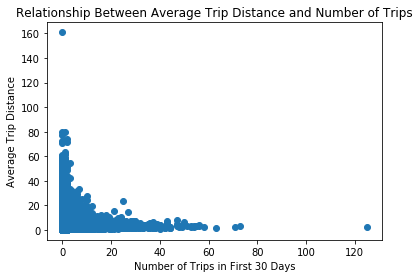

In [39]:
plt.scatter(df['trips_in_first_30_days'], df['avg_dist'])
plt.ylabel('Average Trip Distance')
plt.xlabel('Number of Trips in First 30 Days')
plt.title('Relationship Between Average Trip Distance and Number of Trips')
plt.show()

It does look like there are two wild outliers, one with a very large number of trips and one with a very long trip. Since these are only two records, I will drop them.

In [40]:
df = df[df['trips_in_first_30_days'] < 100]
df = df[df['avg_dist'] < 100]
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,49602.000000,49602.000000,49602.000000,49602.000000,49602.000000,49602.000000,49602.000000
mean,2.274828,4.601474,1.074991,8.875382,60.882819,5.782366,4.777862
std,3.753126,0.565236,0.222670,19.989366,37.086537,5.626824,0.446229
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.700000,100.000000,6.930000,5.000000
max,73.000000,5.000000,8.000000,100.000000,100.000000,79.690000,5.000000


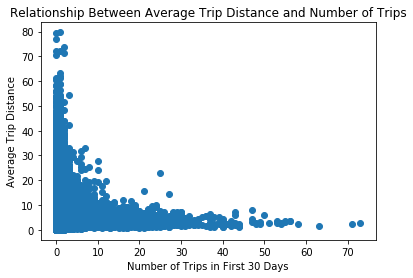

In [41]:
# plot again
plt.scatter(df['trips_in_first_30_days'], df['avg_dist'])
plt.ylabel('Average Trip Distance')
plt.xlabel('Number of Trips in First 30 Days')
plt.title('Relationship Between Average Trip Distance and Number of Trips')
plt.show()

The plot shows data more clustered without outliers.

The original data set had 50000 records and I've retained 49602 or 99.2% of the data.

Now I need to create a column showing whether the user was retained, which is whether their last trip date is less than one month ago. Since I don't know when this data was pulled, I'm going to assume it was pulled on the most recent last trip date.

In [53]:
# convert date columns from string to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# while I'm at it, I'll convert ultimate_black_user to 1s and 0s and create dummy columns for catetorical data
df['ultimate_black_user'] = df['ultimate_black_user'].apply(lambda x: 1 if x else 0)
df = pd.get_dummies(df)

In [61]:
# create column 'retained' that records a 1 if the last trip date was less than one month before the 
# most recent last trip date

most_recent_trip_cutoff = df['last_trip_date'].max() - timedelta(days=30)

df['retained'] = df['last_trip_date'].apply(lambda x: 1 if x > most_recent_trip_cutoff else 0)
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,retained
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,0,1,0,0,1,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,1,0,0,0,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,0,1,0,0,1,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,0,1,1,0,0


In [92]:
# calculate percentage of retained users
pct_retained = 100*df[df['retained'] == 1]['retained'].count()/df['retained'].count()
print('Percentage of users retained: {}%'.format(round(pct_retained, 2)))

Percentage of users retained: 36.65%


I'd like to look at the correlation between retention and other columns.

In [88]:
c= df.corr()
retained_c = pd.DataFrame(c['retained'])

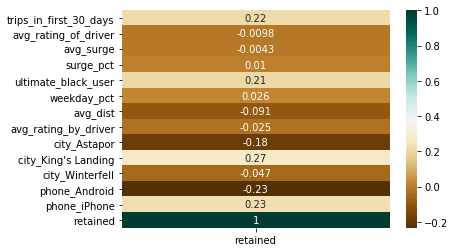

In [89]:
sns.heatmap(retained_c,cmap='BrBG',annot=True)
plt.show()

Phone type, city, and number of trips in first 30 days seem to have the strongest correlations with retention.

## Predictive Model ##

Goal is to create a predictive model to help Ultimate determine whether or not a user will be active in their sixth month in the system. 

First I need to create smaller dataset of users who have been in the system for at least six months, and whether they were active in their sixth month.

In [103]:
last_trip = df['last_trip_date'].max()
date_6mo = last_trip - timedelta(days=180)

df_6mo = df[df['signup_date'] <= date_6mo].copy()
df_6mo.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,retained
count,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000,2723.000000
mean,1.654793,4.590373,1.080602,8.643739,0.375689,64.886045,5.645402,4.770814,0.325009,0.183988,0.491003,0.288652,0.711348,0.379361
std,3.145358,0.564544,0.287310,20.354421,0.484389,35.809550,5.259156,0.456343,0.468464,0.387546,0.500011,0.453219,0.453219,0.485317
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000,1.000000,0.000000,0.000000,42.900000,2.450000,4.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,4.700000,1.000000,0.000000,0.000000,69.900000,3.780000,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,2.000000,5.000000,1.040000,7.100000,1.000000,100.000000,6.645000,5.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,54.000000,5.000000,8.000000,100.000000,1.000000,100.000000,41.830000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


This leaves is only 2723 users out of the full data set are older than 6 months. 

This is a classification problem, i.e. determining whether users are retained or not, so I will start with LogisticRegression and see how that performs.

In order to perform machine learning on this data, I need to convert dates to meaningful numbers.

In [105]:
# create a column for number of days since signup and number of days since last trip
df_6mo['signup_days'] = (last_trip - df_6mo['signup_date']).dt.days
df_6mo['last_trip_days'] = (last_trip - df_6mo['last_trip_date']).dt.days
df_6mo.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,retained,signup_days,last_trip_days
19,0,2014-01-02,5.000000,1.17,2014-06-03,33.3,0,66.7,12.08,5.0,0,1,0,0,1,1,180,28
25,1,2014-01-02,4.601559,1.00,2014-01-03,0.0,1,100.0,14.48,5.0,0,0,1,0,1,0,180,179
37,0,2014-01-02,4.000000,1.00,2014-04-26,0.0,0,50.0,1.38,5.0,1,0,0,0,1,0,180,66
51,4,2014-01-02,4.500000,1.00,2014-05-02,0.0,0,52.4,3.24,5.0,0,0,1,1,0,0,180,60
68,0,2014-01-01,5.000000,1.00,2014-06-15,0.0,1,0.0,4.44,5.0,0,1,0,0,1,1,181,16


In [106]:
# assign X and y, features and response arrays
y = np.array(df_6mo['retained'])
X = df_6mo.drop(columns=['signup_date', 'last_trip_date', 'retained'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

In [109]:
# perform logistic regression
log = LogisticRegression(max_iter=1000)
log.fit(X_train, y_train)
log_score = log.score(X_test, y_test)
print('Logistic Regression Score: {}'.format(log_score))

Logistic Regression Score: 0.9951040391676866


In [111]:
# view confusion matrix
pred = log.predict(X_test)
c=confusion_matrix(y_test, pred)
print(c)

[[519   0]
 [  4 294]]


I chose logistic regression because it is quite fast, and therefore is usually my first choice of classifiers. It ended up performing extremely well, so for this exercise, I'm not going to try other classification algorithms. The accuracy score is over 99%, and the confusion matrix shows 4 false positives and 0 false negatives, indicating a very useful model.

Actually, it is so accurate that I am somewhat concerned about contamination, e.g. some feature being too strongly correllated with the label y. When I look into feature coefficients in the next section, this will become more apparent.

## Insights ##

Feature coefficients can be used as a rough approximation of feature importance if the features are scaled first. So I will re-run the LogisticRegression with scaling and then examine feature coefficients.

In [118]:
# scale data
scaler = StandardScaler()
X_train_trans = scaler.fit_transform(X_train)
X_test_trans = scaler.transform(X_test)

In [120]:
# redo logistic regression with scaled data
log.fit(X_train_trans, y_train)
log_score = log.score(X_test_trans, y_test)
print('Logistic Regression Score: {}'.format(log_score))

Logistic Regression Score: 0.9951040391676866


In [121]:
# view confusion matrix
pred = log.predict(X_test_trans)
c=confusion_matrix(y_test, pred)
print(c)

[[516   3]
 [  1 297]]


The fit is still good, the confusion matrix is a little more even.

Here are the features and their importances.

In [137]:
importance = log.coef_[0]
feature_dict = {}
for i, val in enumerate(importance):
    feature_dict[X_train.columns[i]] = val

feature_df = pd.DataFrame(feature_dict, index=[0]).transpose()

In [138]:
feature_df.columns = ['feature_importance']
feature_df = feature_df.sort_values('feature_importance')

In [139]:
feature_df

,feature_importance
last_trip_days,-10.950820
phone_Android,-0.161688
city_Astapor,-0.155200
city_Winterfell,-0.146842
surge_pct,-0.124062
avg_rating_by_driver,-0.114476
avg_rating_of_driver,-0.105663
signup_days,0.023957
avg_dist,0.026933
weekday_pct,0.117697


## Conclusions ##

Based on this information, some advice I might give is:
* If you only do one thing, give a coupon or other incentive to users who have gone too long since their last ride, since this is by far the strongest predictor of retention
* Look into whether the app is harder to use on an Android, since Android use has a negative impact on retention
* Give coupons to users in Astapor and Winterfell
* Incentivize taking trips in the first 30 days and potentially taking trips on weekedays, since they have a small positive impact on retention
* Promote the Ultimate Black membership more